# Parte 1: Importação dos Arquivos

Nesta etapa, realizamos a extração da pasta do arquivo `.zip`.  
**Observação:** Antes, é necessário fazer o upload do arquivo `.zip` no Colab.



In [ ]:
import zipfile

# Nome do arquivo zip (mude se for diferente)
zip_path = "data\Acordes.zip"

# Caminho de destino para extração
extract_path = "data"

# Extraindo
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


# Parte 2: Extração de Atributos

Nesta etapa, utilizamos a biblioteca **Librosa**, especializada em processamento de áudio, para extrair atributos relevantes.

Documentação de referência:  
https://librosa.org/doc/latest/generated/librosa.feature.mfcc.html#librosa.feature.mfcc


In [2]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração inicial
pasta = 'data/Acordes/Acordes'
lista_arquivos = os.listdir(pasta)
arquivos_audio = []

# Filtra arquivos .wav de acordes maiores/menores
for arquivo in lista_arquivos:
    if (arquivo.startswith('Major') or arquivo.startswith('Minor')) and arquivo.endswith('.wav'):
        arquivos_audio.append(os.path.join(pasta, arquivo))

dataset = []

for filepath in arquivos_audio:
    y, sr = librosa.load(filepath, sr=None)

    # --- Atributos temporais ---
    rms = librosa.feature.rms(y=y).mean()

    # --- Atributos espectrais ---
    # Chroma STFT
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_stft_mean = chroma_stft.mean()
    chroma_stft_std = chroma_stft.std()

    # Chroma CQT
    chroma_cqt = librosa.feature.chroma_cqt(y=y, sr=sr)
    chroma_cqt_mean_vector = chroma_cqt.mean(axis=1) + 1e-9  # evitar divisão por zero
    chroma_cqt_mean = chroma_cqt_mean_vector.mean()
    chroma_cqt_std = chroma_cqt.std()

    # Tonnetz (relações harmônicas)
    tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)
    tonnetz_mean = tonnetz.mean(axis=1)

    # MFCCs (timbre)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=5)
    mfcc_means = [mfcc[i].mean() for i in range(3)]  # Apenas os 3 primeiros coeficientes

    # --- Novos atributos sugeridos ---
    # Razão harmônica/percussiva
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    harmonic_ratio = np.mean(y_harmonic ** 2) / (np.mean(y_harmonic ** 2) + np.mean(y_percussive ** 2))

    # Interval Ratios (baseado em chroma_cqt)
    root_idx = np.argmax(chroma_cqt_mean_vector)

    def energy(semitone_offset):
        return chroma_cqt_mean_vector[(root_idx + semitone_offset) % 12]

    ratio_minor_3rd = energy(3) / chroma_cqt_mean_vector[root_idx]
    ratio_major_3rd = energy(4) / chroma_cqt_mean_vector[root_idx]
    ratio_minor_major = ratio_minor_3rd / ratio_major_3rd

    # --- Classe ---
    filename = os.path.basename(filepath)
    classe = 'major' if filename.startswith('Major') else 'minor'

    # Armazena os atributos
    data = {
        'filename': filename,
        'rms': rms,
        'chroma_stft_mean': chroma_stft_mean,
        'chroma_stft_std': chroma_stft_std,
        'chroma_cqt_mean': chroma_cqt_mean,
        'chroma_cqt_std': chroma_cqt_std,
        'tonnetz_t1': tonnetz_mean[0],
        'tonnetz_t2': tonnetz_mean[1],
        'tonnetz_t3': tonnetz_mean[2],
        'tonnetz_t4': tonnetz_mean[3],
        'tonnetz_t5': tonnetz_mean[4],
        'tonnetz_t6': tonnetz_mean[5],
        'mfcc1': mfcc_means[0],
        'mfcc2': mfcc_means[1],
        'mfcc3': mfcc_means[2],
        'harmonic_ratio': harmonic_ratio,
        'ratio_minor_3rd': ratio_minor_3rd,
        'ratio_major_3rd': ratio_major_3rd,
        'ratio_minor_major': ratio_minor_major,
        'class': classe
    }

    dataset.append(data)

# Converte para DataFrame
df = pd.DataFrame(dataset)


c:\Users\Ismael Soares\Documents\Faculdade\Reconhecimento de Padrões\Acordes-Maiores-e-Menores-KNN\acordesvenv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=776
  warnings.warn(
c:\Users\Ismael Soares\Documents\Faculdade\Reconhecimento de Padrões\Acordes-Maiores-e-Menores-KNN\acordesvenv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=776
  warnings.warn(
c:\Users\Ismael Soares\Documents\Faculdade\Reconhecimento de Padrões\Acordes-Maiores-e-Menores-KNN\acordesvenv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=758
  warnings.warn(
c:\Users\Ismael Soares\Documents\Faculdade\Reconhecimento de Padrões\Acordes-Maiores-e-Menores-KNN\acordesvenv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=793
  warnings.warn(


# Parte 3: Análise Exploratória

Realizamos duas análises importantes:

1. **Matriz de Correlação:** para identificar relações entre as features extraídas.
2. **Boxplots:** para visualizar a distribuição das principais features por classe (major ou minor).


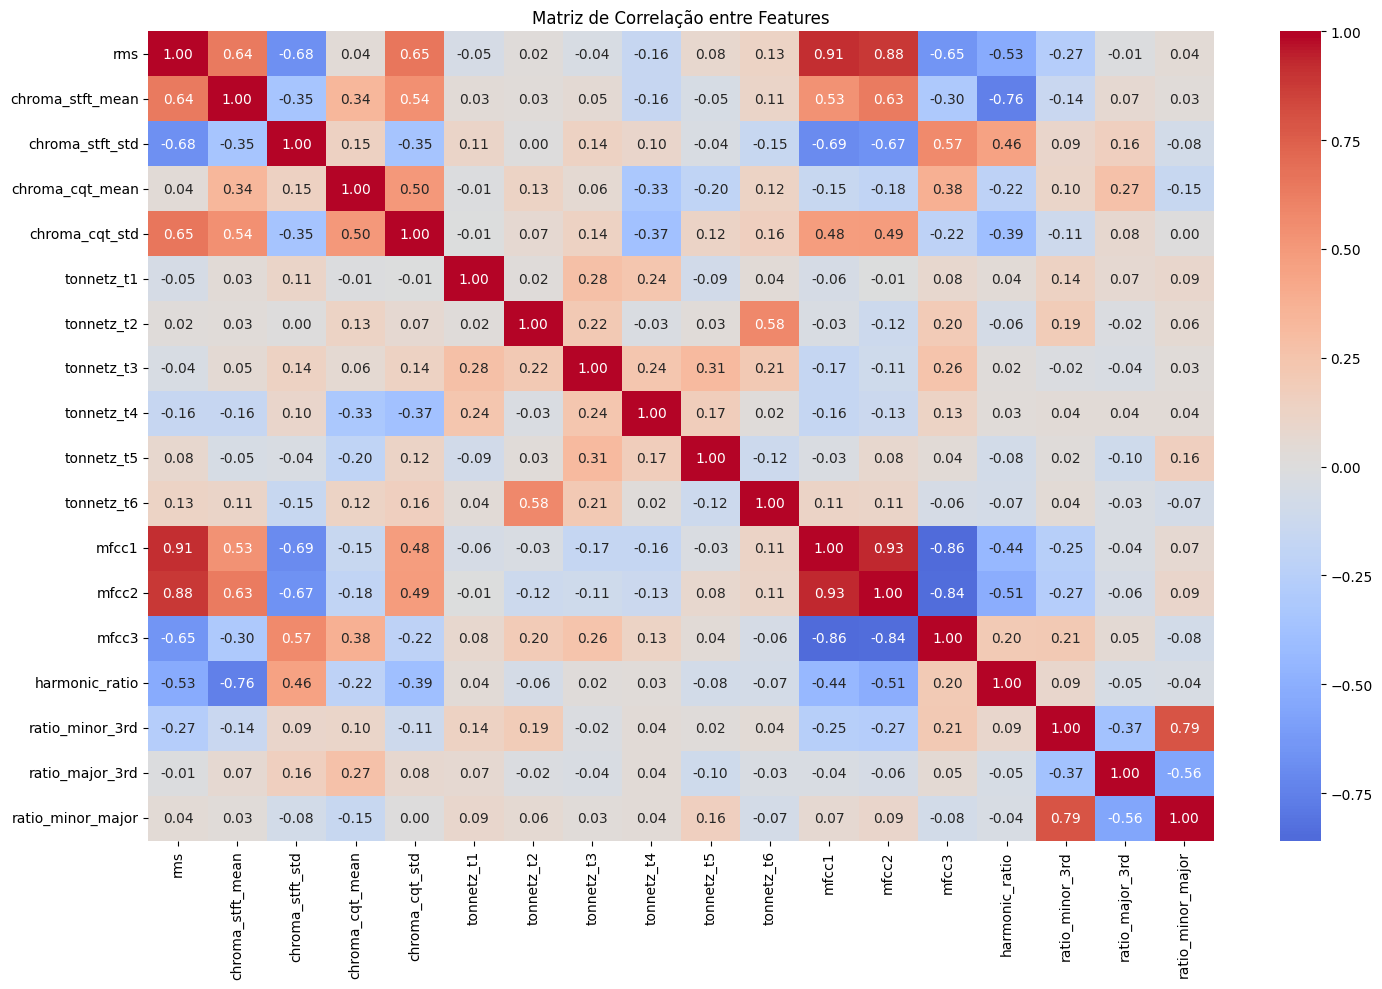

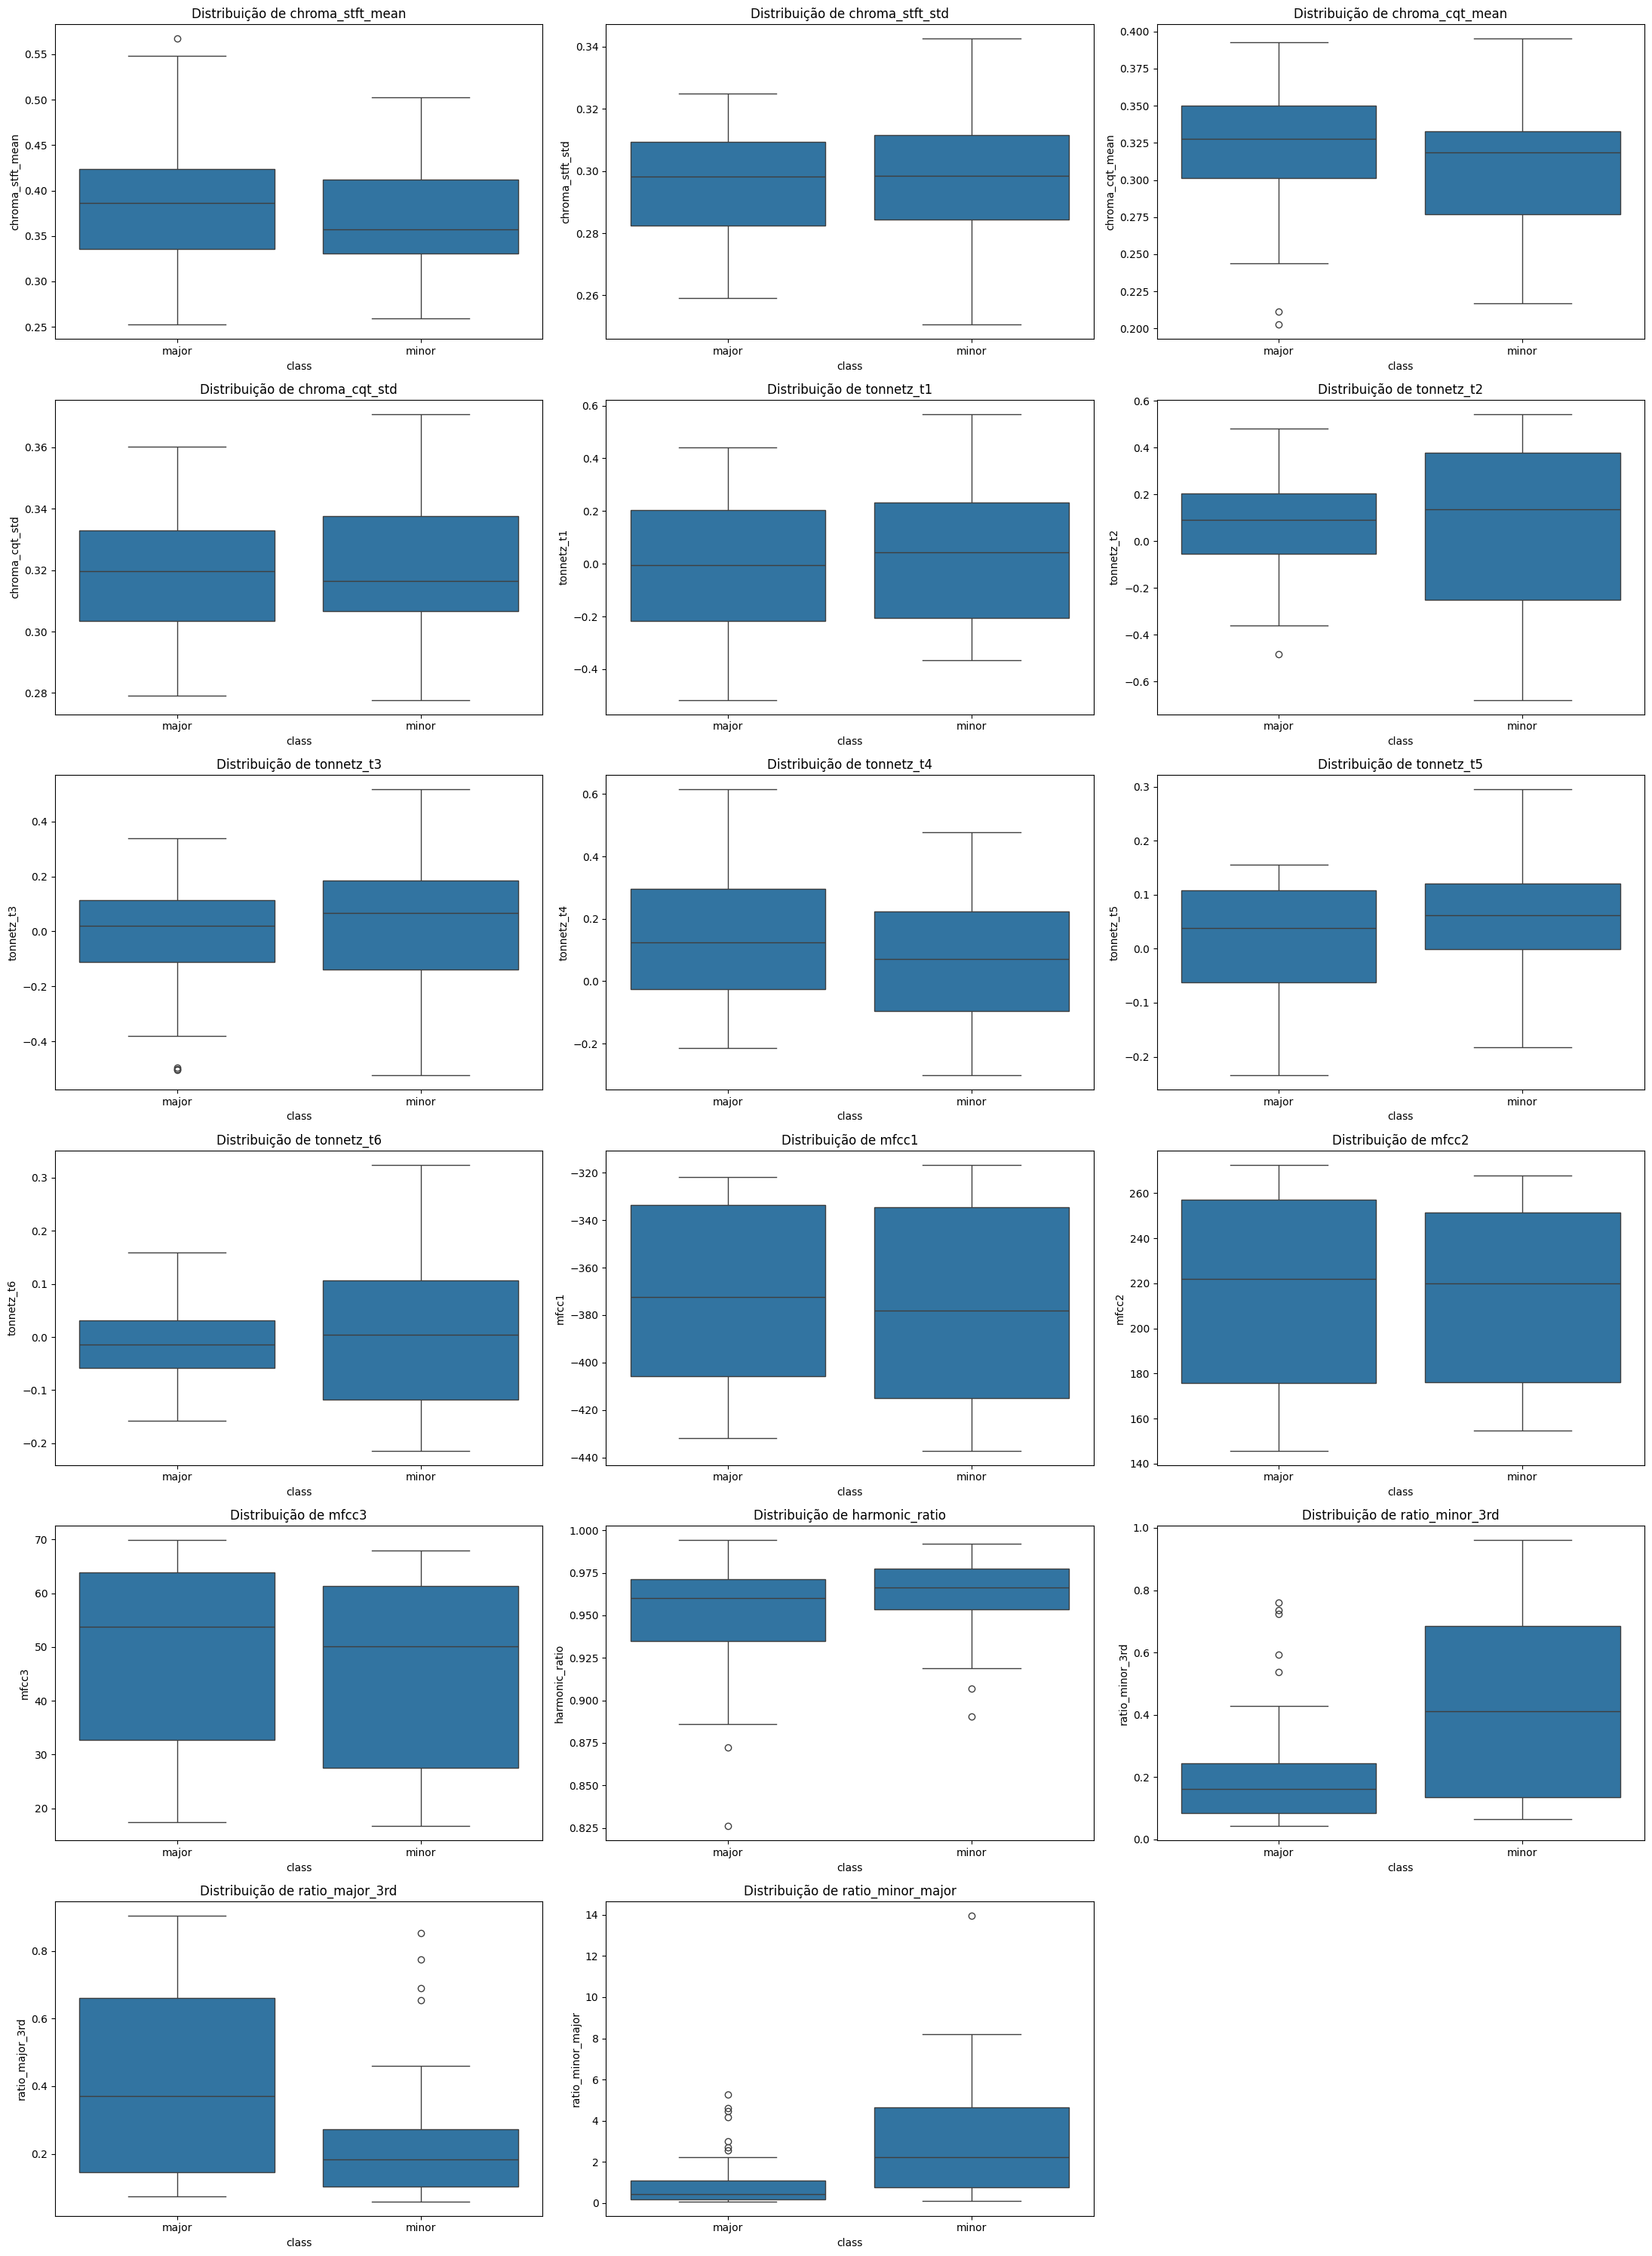

In [4]:
# --- Análise Exploratória ---

# 1. Matriz de Correlação entre Features
plt.figure(figsize=(15, 10))
corr = df.drop(['filename', 'class'], axis=1).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Matriz de Correlação entre Features')
plt.tight_layout()
plt.show()

# 2. Boxplots por Classe para Features Principais
features_principais = [
    'chroma_stft_mean', 'chroma_cqt_mean',
    'tonnetz_t1', 'mfcc1',
    'harmonic_ratio', 'ratio_minor_major'  # Adicionando uma nova feature importante
]

# Lista completa de features (atualizada)
features_completas = [
    'chroma_stft_mean', 'chroma_stft_std',
    'chroma_cqt_mean', 'chroma_cqt_std',
    'tonnetz_t1', 'tonnetz_t2', 'tonnetz_t3',
    'tonnetz_t4', 'tonnetz_t5', 'tonnetz_t6',
    'mfcc1', 'mfcc2', 'mfcc3',
    'harmonic_ratio',
    'ratio_minor_3rd', 'ratio_major_3rd', 'ratio_minor_major'
]

plt.figure(figsize=(22, 30))  # Aumentamos ainda mais o tamanho da figura

# Grid dinâmica baseada na quantidade de features
n_features = len(features_completas)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols  # Arredondamento para cima

for i, feature in enumerate(features_completas, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(x='class', y=feature, data=df)
    plt.title(f'Distribuição de {feature}')
    
plt.tight_layout()
plt.show()


# Parte 4: Normalização dos Dados

Antes de treinar o modelo, realizamos a **normalização z-score** das features para garantir que todas estejam na mesma escala.


In [ ]:
import os
import numpy as np
import librosa
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Caminho dos arquivos
pasta = "data/Acordes/Acordes"  # substitua pelo seu caminho real
lista_arquivos = os.listdir(pasta)
arquivos_audio = []

# Filtrar arquivos que são maior ou menor
for arquivo in lista_arquivos:
    if (arquivo.startswith('Major') or arquivo.startswith('Minor')) and arquivo.endswith('.wav'):
        arquivos_audio.append(os.path.join(pasta, arquivo))

dataset = []

for filepath in arquivos_audio:
    y, sr = librosa.load(filepath, sr=None)  # Carrega o arquivo com librosa para extrair features avançadas
    
    # --- Extração de todas as features ---
    
    # Chroma STFT
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_stft_mean = np.mean(chroma_stft)
    chroma_stft_std = np.std(chroma_stft)

    # Chroma CQT
    chroma_cqt = librosa.feature.chroma_cqt(y=y, sr=sr)
    chroma_cqt_mean = chroma_cqt.mean(axis=1) + 1e-9  # evitar divisão por zero
    chroma_cqt_std = np.std(chroma_cqt)

    # Tonnetz
    tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)
    tonnetz_mean = tonnetz.mean(axis=1)  # Média por coeficiente

    # MFCCs (pegando os 3 primeiros coeficientes)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=5)
    mfcc1 = np.mean(mfcc[0])
    mfcc2 = np.mean(mfcc[1])
    mfcc3 = np.mean(mfcc[2])

    # Razão harmônica/percussiva
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    harmonic_ratio = np.mean(y_harmonic ** 2) / (np.mean(y_harmonic ** 2) + np.mean(y_percussive ** 2))

    # RMS (Energia do sinal)
    rms = librosa.feature.rms(y=y).mean()

    # Interval Ratios
    root_idx = np.argmax(chroma_cqt_mean)
    def energy(semitone_offset):
        return chroma_cqt_mean[(root_idx + semitone_offset) % 12]
    
    ratio_minor_3rd = energy(3) / chroma_cqt_mean[root_idx]
    ratio_major_3rd = energy(4) / chroma_cqt_mean[root_idx]
    ratio_minor_major = ratio_minor_3rd / ratio_major_3rd

    # Classe (Major ou Minor)
    filename = os.path.basename(filepath)
    classe = '1' if filename.startswith('Major') else '0'

    dataset.append({
        'filename': filename,
        'class': classe,
        'chroma_stft_mean': chroma_stft_mean,
        'chroma_stft_std': chroma_stft_std,
        'chroma_cqt_mean': np.mean(chroma_cqt_mean),
        'chroma_cqt_std': chroma_cqt_std,
        'tonnetz_t1': tonnetz_mean[0],
        'tonnetz_t2': tonnetz_mean[1],
        'tonnetz_t3': tonnetz_mean[2],
        'tonnetz_t4': tonnetz_mean[3],
        'tonnetz_t5': tonnetz_mean[4],
        'tonnetz_t6': tonnetz_mean[5],
        'mfcc1': mfcc1,
        'mfcc2': mfcc2,
        'mfcc3': mfcc3,
        'harmonic_ratio': harmonic_ratio,
        'rms': rms,
        'ratio_minor_3rd': ratio_minor_3rd,
        'ratio_major_3rd': ratio_major_3rd,
        'ratio_minor_major': ratio_minor_major
    })

# Criar DataFrame
df = pd.DataFrame(dataset)

# Lista com todas as features (excluindo filename e class)
features_completas = [
    'chroma_stft_mean', 'chroma_stft_std',
    'chroma_cqt_mean', 'chroma_cqt_std',
    'tonnetz_t1', 'tonnetz_t2', 'tonnetz_t3',
    'tonnetz_t4', 'tonnetz_t5', 'tonnetz_t6',
    'mfcc1', 'mfcc2', 'mfcc3',
    'harmonic_ratio',
    'rms',
    'ratio_minor_3rd', 'ratio_major_3rd', 'ratio_minor_major'
]

# Normalização z-score
scaler = StandardScaler()
df_normalizado = df.copy()
df_normalizado[features_completas] = scaler.fit_transform(df[features_completas])

# Exibir os primeiros registros para conferência
print("DataFrame com todas as features normalizadas:")
print(df_normalizado.head())

# Mostrar estatísticas descritivas
print("\nEstatísticas descritivas:")
print(df_normalizado[features_completas].describe())


# Parte 5: Seleção de Features com Random Forest

Aplicamos o algoritmo **Random Forest** para avaliar a importância de cada feature extraída, identificando as mais relevantes para classificação.


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Preparando os dados
X = df_normalizado[features_completas]
y = df_normalizado['class'].astype(int)  # Convertendo para numérico

# Dividindo em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Criando e treinando o modelo Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Obtendo as importâncias das features
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features_completas,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Visualizando as importâncias
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance - Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

# Avaliando o modelo
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia do Random Forest: {accuracy:.4f}")

# Selecionando as 3 melhores features
features_principais = feature_importance_df['Feature'].head(2).tolist()

# Parte 6: K-Fold

Implementamos a técnica de **validação cruzada k-fold**, garantindo uma avaliação robusta do modelo.  
O conjunto de dados é dividido estratificadamente em 10 folds.


In [ ]:
import numpy as np
import pandas as pd

def create_folds(df, k=10, seed=42):
    np.random.seed()

    # Obtém os índices das amostras para cada classe
    index_menor = df[df['class'] == '0'].index.to_numpy()
    index_maior = df[df['class'] == '1'].index.to_numpy()

    # Embaralha os índices
    np.random.shuffle(index_menor)
    np.random.shuffle(index_maior)

    # Divide os índices em k partes (folds) de forma sequencial
    folds_menor = np.array_split(index_menor, k)
    folds_maior = np.array_split(index_maior, k)

    folds = []
    for i in range(k):
        fold = np.concatenate([folds_menor[i], folds_maior[i]])
        np.random.shuffle(fold)
        folds.append(fold)

    return folds

# Exemplo de uso:
folds = create_folds(df_normalizado)

for i, fold in enumerate(folds):
    print(f"Fold {i+1}: {fold}")

# Parte 7: Preditor KNN

Desenvolvemos um **classificador KNN (K-Nearest Neighbors)** manual, com as seguintes etapas:

- Cálculo das distâncias euclidianas.
- Seleção dos k vizinhos mais próximos.
- Predição com base na maioria das classes.
- Avaliação de desempenho (TP, FP e acurácia).


In [ ]:
def knn_predict(df, train_idx, val_idx, features, k=3):
    """
    Realiza predição KNN para um fold de validação dado:
    - df: DataFrame com dados
    - train_idx: índices do conjunto de treino
    - val_idx: índices do conjunto de validação
    - features: lista com os nomes das colunas dos atributos
    - k: número de vizinhos
    Retorna o número de verdadeiros positivos, falsos positivos e acurácia.
    """
    TP = 0
    FP = 0

    for idx_val in val_idx:
        val_vector = df.loc[idx_val, features].to_numpy()
        val_class = df.loc[idx_val, 'class']

        # Calcula distâncias para todos os de treino
        distances = []
        for idx_train in train_idx:
            train_vector = df.loc[idx_train, features].to_numpy()
            dist = euclidean_distance(val_vector, train_vector)
            train_class = df.loc[idx_train, 'class']
            distances.append((dist, train_class))

        # Ordena as distâncias
        distances.sort(key=lambda x: x[0])

        # Pega os k vizinhos mais próximos
        k_nearest = distances[:k]

        # Conta classes entre os vizinhos
        classes = [c for _, c in k_nearest]
        pred_class = max(set(classes), key=classes.count)

        # Verifica acerto
        if pred_class == val_class:
            TP += 1
        else:
            FP += 1

    accuracy = TP / (TP + FP) if (TP + FP) > 0 else 0
    return TP, FP, accuracy

# Distância Euclidiana
def euclidean_distance(vec1, vec2):
    return np.sqrt(np.sum((vec1 - vec2) ** 2))

import numpy as np

def run_kfold_knn(df, features, k_folds=10, k_neighbors=3):
    """
    Executa validação cruzada k-fold usando KNN.
    """
    folds = create_folds(df, k=k_folds)
    results = []

    for i in range(k_folds):
        val_idx = folds[i]
        train_idx = np.concatenate([folds[j] for j in range(k_folds) if j != i])

        TP, FP, acc = knn_predict(df, train_idx, val_idx, features, k=k_neighbors)
        results.append({'fold': i+1, 'TP': TP, 'FP': FP, 'accuracy': acc})

    return results

def grid_search_knn(df, features, k_folds=10, k_values=[1, 3, 5, 7, 9]):
    """
    Realiza busca em grade (grid search) sobre diferentes valores de k para o KNN.
    """
    grid_results = []

    for k in k_values:
        fold_results = run_kfold_knn(df, features, k_folds=k_folds, k_neighbors=k)
        accuracies = [res['accuracy'] for res in fold_results]
        mean_accuracy = np.mean(accuracies)
        
        grid_results.append({
            'k': k,
            'mean_accuracy': mean_accuracy,
            'all_accuracies': accuracies
        })
    
    return grid_results


### Fazendo as Predições com o KNN Manual

Utilizamos as **N melhores features** selecionadas via Random Forest para realizar as predições usando o KNN implementado manualmente.  
Realizamos um **grid search** com diferentes valores de `k` (3, 5, 7 e 9).


In [ ]:
# Selecionando as N melhores features da feature importance
features_principais = feature_importance_df['Feature'].head(3).tolist()

# Rodando o grid search para k = 1, 3, 5, 7, 9
resultados_grid = grid_search_knn(df_normalizado, features_principais, k_folds=10, k_values=[3, 5, 7, 9])

for res in resultados_grid:
    print(f"k = {res['k']}, Acurácia média = {res['mean_accuracy']:.4f}")

### Comparando com o KNN do Scikit-Learn

Para validar nossa implementação manual, comparamos os resultados com a versão do **KNN** da biblioteca **Scikit-Learn** utilizando:

- `GridSearchCV` para busca pelos melhores parâmetros.
- `KFold` com 10 divisões e embaralhamento.


In [ ]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier

# Separando features e target
X = df_normalizado[features_principais].values
y = df_normalizado['class'].values

# Definindo o modelo KNN
knn = KNeighborsClassifier()

# Definindo os parâmetros para o grid search
param_grid = {'n_neighbors': [3, 5, 7, 9]}

# Configurando o KFold com embaralhamento e seed
cv = KFold(n_splits=10, shuffle=True)

# Configurando o grid search com o KFold customizado
grid_search = GridSearchCV(knn, param_grid, cv=cv, scoring='accuracy')

# Ajustando o modelo
grid_search.fit(X, y)

# Resultados
for mean, params in zip(grid_search.cv_results_['mean_test_score'], grid_search.cv_results_['params']):
    print(f"k = {params['n_neighbors']}, Acurácia média = {mean:.4f}")


# ✅ **Conclusão - Comparação entre KNN Manual e Scikit-Learn**

Com base nos resultados obtidos, podemos destacar os seguintes pontos importantes:

- ✅ **Desempenho:**  
Ambas as implementações apresentaram **acurácias médias bastante próximas**, com pequenas flutuações dependendo da execução e do valor de `k`.

- ✅ **Robustez:**  
O **KNN manual** demonstrou desempenho competitivo, validando a correta implementação do algoritmo.  
Já o **KNN do Scikit-Learn**, apesar de ser uma "caixa-preta", é altamente otimizado, garantindo resultados rápidos e eficientes.

- ✅ **Variações nas execuções:**  
As diferenças entre as execuções ocorrem principalmente devido à **aleatoriedade na divisão dos folds** durante a validação cruzada, além de pequenas nuances na implementação do cálculo das distâncias e seleção dos vizinhos.

- ✅ **Eficiência:**  
A utilização do **Scikit-Learn** se destaca pela **praticidade e velocidade**, sendo ideal para aplicações profissionais e em larga escala.  
Por outro lado, a **implementação manual** é fundamental para fins educacionais, proporcionando uma **compreensão aprofundada** do funcionamento interno do algoritmo.

---

🎯 **Em resumo:**  
A prática de desenvolver o KNN manualmente, comparando-o com a biblioteca Scikit-Learn, é uma excelente abordagem para consolidar o entendimento teórico e verificar na prática a eficácia das técnicas de Machine Learning.
